# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

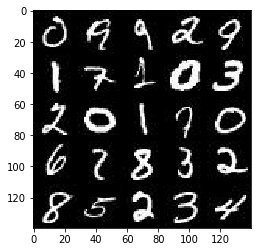

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray');

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

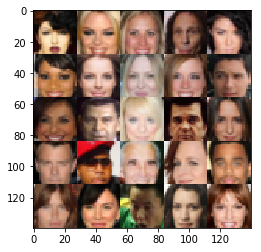

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'));

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    def leaky_relu(h, alpha=0.2):
        return tf.maximum(alpha * h, h)
    
    def fully_connected_normalized_discriminator(prev_layer, input_units):
        layer = tf.reshape(prev_layer, shape=(-1, input_units))
        logits = tf.layers.dense(layer, units=1,activation=None)
        out = tf.sigmoid(logits)
        return out, logits
        
    def conv2d_normalized(prev_layer, num_units=64, k_size=5, strides=2, alpha=0.2, needNormal=True):
                
        layer = tf.layers.conv2d(prev_layer, num_units, k_size, strides,  
                                 use_bias=False, 
                                 activation=None,
                                padding='same')
        if needNormal:
            batch_normalized_output = tf.layers.batch_normalization(layer, training=True)                
            return leaky_relu(batch_normalized_output, alpha)
        else:
            return leaky_relu(layer, alpha)
    
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        k_size = 5
        strides = 2
        first_layer_depth = 64
        alpha = 0.2
        layer_depth = first_layer_depth
        deep_layer = conv2d_normalized(images, 
                                       num_units=layer_depth, 
                                       k_size=k_size, 
                                       strides=strides, 
                                       alpha=alpha, needNormal=False)
        deep_layer = tf.layers.dropout(deep_layer, keep_prob, training=True)
        layer_depth = int(layer_depth*strides)
        deep_layer = conv2d_normalized(deep_layer, 
                                       num_units=layer_depth, 
                                       k_size=k_size, 
                                       strides=strides, 
                                       alpha=alpha)
        
        
        layer_depth = int(layer_depth*strides)
        deep_layer = conv2d_normalized(deep_layer, 
                                       num_units=layer_depth, 
                                       k_size=k_size, 
                                       strides=strides, 
                                       alpha=alpha)
        
        
        final_layer_shape = deep_layer.get_shape().as_list()
        input_units = final_layer_shape[1]*final_layer_shape[2]*final_layer_shape[3]
        out, logits = fully_connected_normalized_discriminator(deep_layer, input_units=input_units)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    def leaky_relu(h, alpha):
        return tf.maximum(alpha * h, h)
    
    def fully_connected_normalized_generator(z, num_units, shape, alpha=0.2):
        x = tf.layers.dense(z, units=num_units,activation=None)
        layer = tf.reshape(x, shape)
        batch_normalized_output = tf.layers.batch_normalization(layer, training=is_train)
        return leaky_relu(batch_normalized_output, alpha)
            
    def conv2d_transpose_normalized(prev_layer, num_units, k_size, strides, training, alpha=0.2):
        layer = tf.layers.conv2d_transpose(prev_layer, 
                                 num_units, 
                                 k_size, 
                                 strides, 
                                 padding='same', 
                                 use_bias=False, 
                                 activation=None)       
        batch_normalized_output = tf.layers.batch_normalization(layer, training=training)                
        return leaky_relu(batch_normalized_output, alpha)

    reuse = True if is_train == False else False
    
    with tf.variable_scope('generator', reuse=reuse):
        k_size = 5
        strides = 2
        first_layer_depth = 512
        alpha = 0.2
        # First fully connected layer
        layer_depth = first_layer_depth
        shape = [-1, 7, 7, layer_depth]
        deep_layer = fully_connected_normalized_generator(z, 
                                                 num_units=shape[1]*shape[2]*shape[3], 
                                                 shape=shape, 
                                                 alpha=alpha)                                               
        layer_depth = int(layer_depth/strides)
        deep_layer = conv2d_transpose_normalized(deep_layer, 
                                                 num_units=layer_depth, 
                                                 k_size=k_size, 
                                                 strides=strides, 
                                                 training=is_train, 
                                                 alpha=alpha)                        
        layer_depth = out_channel_dim
        logits = tf.layers.conv2d_transpose(deep_layer, 
                                            filters=layer_depth,  
                                            kernel_size=k_size, 
                                            strides=strides, 
                                            padding='same', 
                                            use_bias=False, 
                                            activation=None)   
        out = tf.tanh(logits)
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    class Gan:
        def __init__(self, real_size, z_size, learning_rate, beta1=0.5):
            self.input_real, self.input_z, self.learning_rate = model_inputs(real_size[1],real_size[2],real_size[3],z_size)
            self.d_loss, self.g_loss = model_loss(self.input_real,self.input_z,real_size[3])
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

    # Create the network
    net = Gan(data_shape, z_dim, learning_rate, beta1=beta1)
    end_of_training = False 
    n_batches = int(data_shape[0]/batch_size)  
    print("Total number of training iterations is {}.".format(n_batches) )
    print()
    
    minimum_iteration = int((8/8)*n_batches)
    training_goal1 = {'ratio_d_g': 2.5,'loss_g': 1,'n_steps':  minimum_iteration}
    training_goal2 = {'ratio_d_g': 20,'loss_g': 5,'n_steps':  minimum_iteration}
    training_goal3 = {'ratio_d_g': 10,'loss_g': 0.5,'n_steps':  minimum_iteration}
    n_images = 25
    print_every = 10
    show_every = 100
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    train_ratio_d_g = train_loss_d/train_loss_g   
                    if (
                        (train_ratio_d_g < training_goal1['ratio_d_g'] and 
                        train_loss_g < training_goal1['loss_g'] and 
                        steps > training_goal1['n_steps']) or 
                        
                        (train_ratio_d_g < training_goal2['ratio_d_g'] and 
                        train_loss_g < training_goal2['loss_g'] and 
                        steps > training_goal2['n_steps']) or 
                        
                        (train_ratio_d_g < training_goal3['ratio_d_g'] and 
                        train_loss_g < training_goal3['loss_g'] and 
                        steps > training_goal3['n_steps'])):
                        
                        end_of_training = True
                        
                        print()
                        print("training goal achieved")
                        
                        show_generator_output(sess, 
                                          n_images = n_images, 
                                          input_z = net.input_z, 
                                          out_channel_dim=data_shape[3], 
                                          image_mode=data_image_mode)
                        
                        break
                if steps % show_every == 0:
                    show_generator_output(sess, 
                                          n_images = n_images, 
                                          input_z = net.input_z, 
                                          out_channel_dim=data_shape[3], 
                                          image_mode=data_image_mode)
            if end_of_training:
                break
        saver.save(sess, './checkpoints/generator_faces.ckpt')
        print("End of training.")              

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Total number of training iterations is 300.

Epoch 1/2... Discriminator Loss: 3.4721... Generator Loss: 3.7374
Epoch 1/2... Discriminator Loss: 2.0376... Generator Loss: 5.8712
Epoch 1/2... Discriminator Loss: 2.1606... Generator Loss: 4.1597
Epoch 1/2... Discriminator Loss: 2.4361... Generator Loss: 2.5999
Epoch 1/2... Discriminator Loss: 1.6400... Generator Loss: 2.3053
Epoch 1/2... Discriminator Loss: 1.8317... Generator Loss: 2.2338
Epoch 1/2... Discriminator Loss: 2.2243... Generator Loss: 1.2482
Epoch 1/2... Discriminator Loss: 1.5664... Generator Loss: 1.5574
Epoch 1/2... Discriminator Loss: 1.7308... Generator Loss: 1.9329
Epoch 1/2... Discriminator Loss: 1.7531... Generator Loss: 2.1510


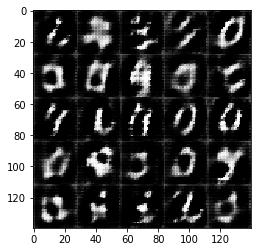

Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.5281
Epoch 1/2... Discriminator Loss: 1.5754... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.4199


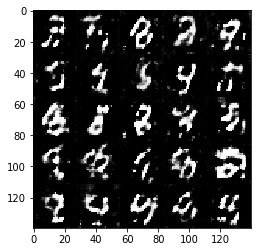

Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 1.4317
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 0.9748


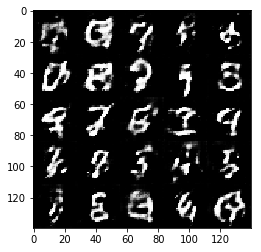

Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 1.8078

training goal achieved


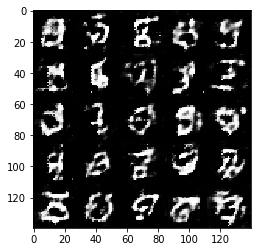

End of training.


In [26]:
batch_size = 200
z_dim = 100
learning_rate = 0.005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Total number of training iterations is 675.

Epoch 1/1... Discriminator Loss: 0.2725... Generator Loss: 11.2058
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 2.1392
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 3.0829
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 4.8489
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 3.5207
Epoch 1/1... Discriminator Loss: 0.2017... Generator Loss: 3.0681
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 3.0108
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.1225... Generator Loss: 3.7831


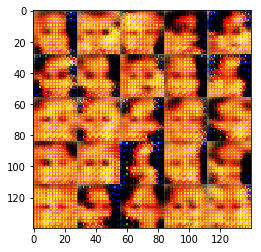

Epoch 1/1... Discriminator Loss: 0.1632... Generator Loss: 3.7130
Epoch 1/1... Discriminator Loss: 0.2967... Generator Loss: 2.4866
Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 4.6588
Epoch 1/1... Discriminator Loss: 0.1481... Generator Loss: 2.7592
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 10.1509
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 2.0963
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 5.7425
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 3.4139
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 3.9433
Epoch 1/1... Discriminator Loss: 0.2586... Generator Loss: 2.4513


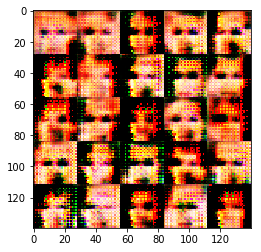

Epoch 1/1... Discriminator Loss: 0.3158... Generator Loss: 2.7796
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 3.5476
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.7809
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 2.0821
Epoch 1/1... Discriminator Loss: 1.8972... Generator Loss: 4.9214
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.2978
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 4.2091
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.6234


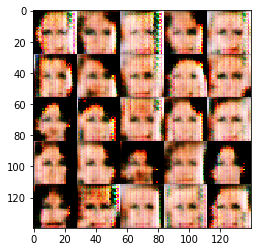

Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 2.2887
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 5.0701
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.8032
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 2.9364
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.7289
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 2.2909
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 1.3749


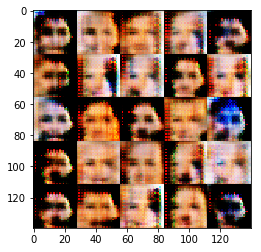

Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 2.3303
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 2.0727
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 2.1045
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 3.0654
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 2.1951
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 2.1182... Generator Loss: 2.4460
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 2.0566
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.2834


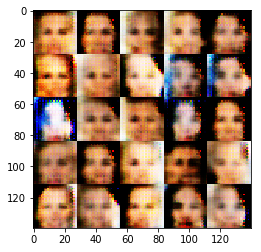

Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 2.6286
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.4674
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.9976


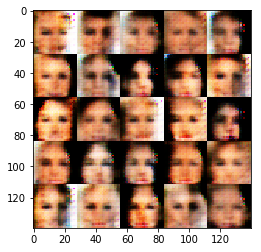

Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.6858
End of training.


In [32]:
batch_size = 300
z_dim = 100
learning_rate = 0.002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。